# Convolutional CVAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)

# Settings

In [3]:
SAVE_NAME = 'cvae.conv'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 100
LR = 3e-04
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Datasets

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)


# Training

In [8]:
input_dim = 222
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92

model = M.cvae.ConvCVAE(input_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()


In [9]:
train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model: pallets.models.cvae.ConvCVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.0003
INFO | epochs: 100
INFO | epoch 1 (  0%) loss: 1418066.250000
INFO | epoch 1 ( 35%) loss: 160301.800046
INFO | epoch 1 ( 70%) loss: 89603.184055
INFO | epoch 1 (100%) loss: 68070.447081
INFO | epoch 1 (test) loss: 13510.715233
INFO | epoch 2 (  0%) loss: 13527.602539
INFO | epoch 2 ( 35%) loss: 13130.250851
INFO | epoch 2 ( 70%) loss: 12677.857825
INFO | epoch 2 (100%) loss: 12337.935211
INFO | epoch 2 (test) loss: 11142.884041
INFO | epoch 3 (  0%) loss: 10860.658203
INFO | epoch 3 ( 35%) loss: 10980.112701
INFO | epoch 3 ( 70%) loss: 10782.032751
INFO | epoch 3 (100%) loss: 10568.975565
INFO | epoch 3 (test) loss: 9901.444809
INFO | epoch 4 (  0%) loss: 10274.592773
INFO | epoch 4 ( 35%) loss: 9784.649636
INFO | epoch 4 ( 70%) loss: 9572.242637
INFO | epoch 4 (100%) loss: 9443.572790
INFO | epoch 4 (test) loss: 8865.763214
INFO | epoch 5 (  0%) loss: 9494.643555
INFO | epoc

# Results

## Random Inputs w/ Real Labels

In [10]:
import random


def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [11]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0]
    decoded_one_hot = decoded_one_hot.view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms w/ Real Labels

Features: male, 3DGlasses, doRag
Shape: torch.Size([4, 24, 24])
torch.Size([4, 24, 24])


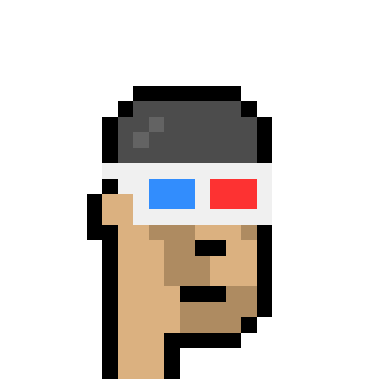

In [12]:
decoded = rand_punk()
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, blueEyeShadow, messyHair, earring
Shape: torch.Size([4, 24, 24])


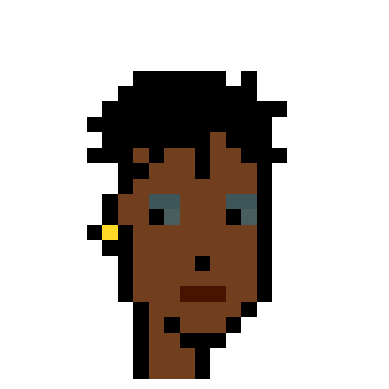

In [13]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, wildBlonde, bigShades
Shape: torch.Size([4, 24, 24])


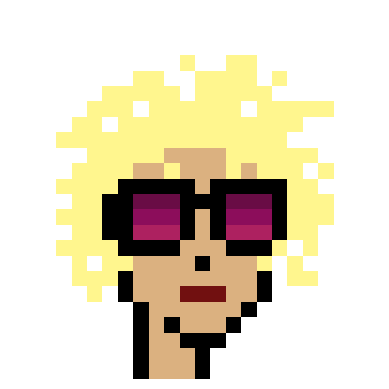

In [14]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, pigtails, cigarette
Shape: torch.Size([4, 24, 24])


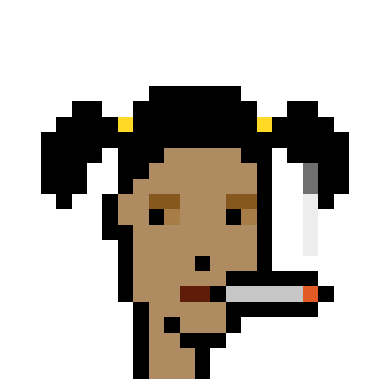

In [15]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, pipe, wildHair, purpleLipstick
Shape: torch.Size([4, 24, 24])


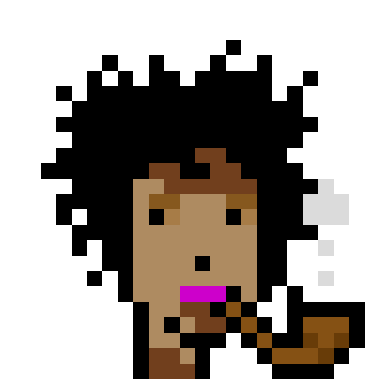

In [16]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [17]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(dataset._label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0].cpu()
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

Features: female, rosyCheeks, darkHair, cigarette


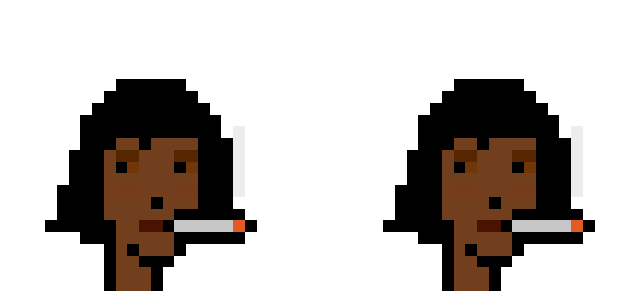

In [18]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


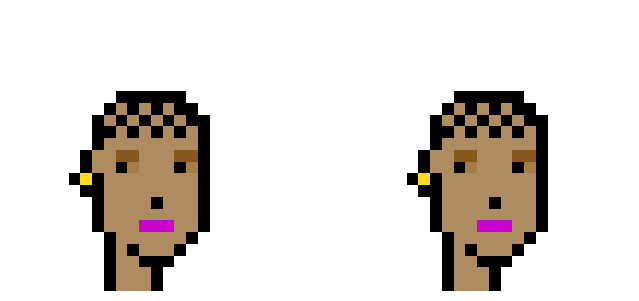

In [19]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


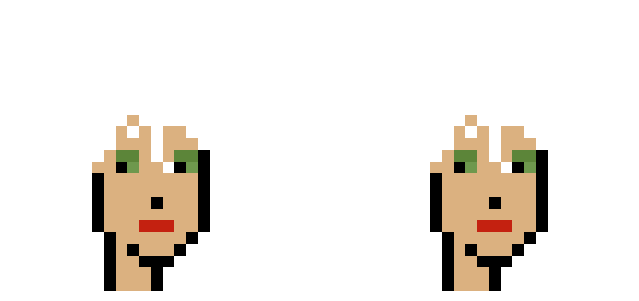

In [20]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


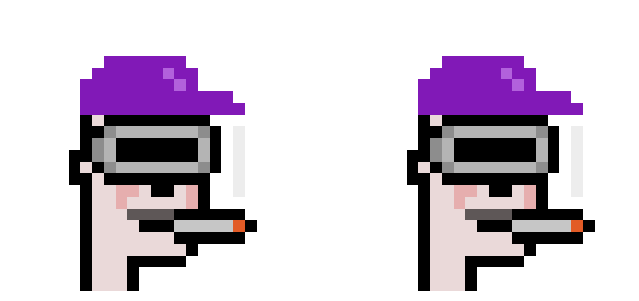

In [21]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


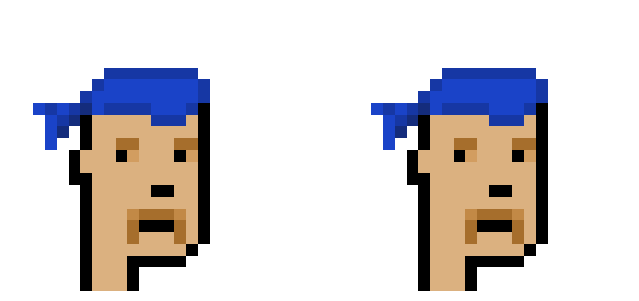

In [22]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

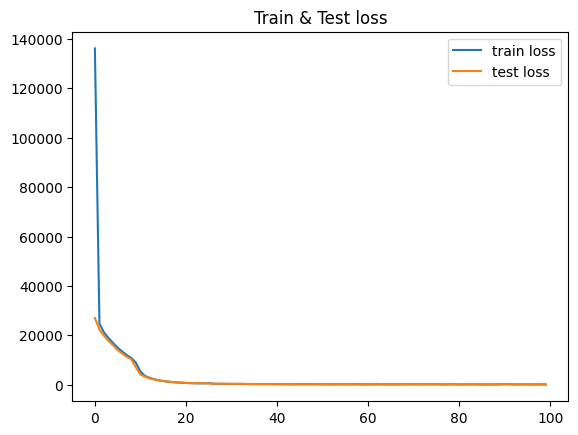

In [23]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [24]:
train_losses


[136140.8941624418,
 24675.87042193041,
 21137.95113031915,
 18887.145580535238,
 16862.201521636747,
 14986.786359638187,
 13421.48207903923,
 12014.384074758977,
 10795.049306883035,
 8911.262562853224,
 5322.543983838237,
 3548.6395012605276,
 2780.770236400848,
 2218.719752534907,
 1793.1775564640127,
 1496.3349099666514,
 1254.5585706453796,
 1053.087729271422,
 920.0060382599527,
 813.0436492270612,
 704.3027132724194,
 629.7923357807998,
 567.0592734695326,
 530.5829149070361,
 539.6737997717892,
 663.30735751754,
 401.4912072039665,
 369.62379082213056,
 362.7072380552901,
 325.3300567518735,
 304.9081934665112,
 288.68342157458585,
 328.69552417511636,
 275.28528505690554,
 267.15066861091776,
 240.28889716939725,
 226.9850948009085,
 224.16004210668254,
 234.00934778037646,
 234.16754085459607,
 193.57726749122565,
 187.54897154138445,
 183.44681833145466,
 170.22887477468936,
 168.17955280195736,
 192.96876966868732,
 161.74053100829428,
 189.55860735845903,
 175.85640259330

In [25]:
test_losses


[27021.430465698242,
 22285.76808166504,
 19802.889617919922,
 17731.526428222656,
 15978.89037322998,
 14014.821060180664,
 12619.812927246094,
 11261.044960021973,
 10298.537986755371,
 7086.849002838135,
 4123.598358154297,
 3295.9058208465576,
 2541.54966545105,
 2103.9972076416016,
 1746.2591361999512,
 1488.5753831863403,
 1252.249743461609,
 1074.7320528030396,
 898.2475337982178,
 864.6217384338379,
 728.4442853927612,
 668.2590794563293,
 599.1001286506653,
 685.8287887573242,
 586.0810761451721,
 487.99500370025635,
 426.3470869064331,
 402.79844903945923,
 393.0121158361435,
 362.6701834201813,
 365.9257242679596,
 334.70473623275757,
 356.63629627227783,
 288.55449509620667,
 305.88356733322144,
 288.6844415664673,
 259.0562207698822,
 244.937646150589,
 261.95062005519867,
 240.59443593025208,
 223.03377962112427,
 211.78378224372864,
 193.05946958065033,
 203.27909231185913,
 188.26802986860275,
 195.71938705444336,
 191.44708061218262,
 190.5074931383133,
 198.9437245130